In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import os
import gc

In [44]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3

def model_picker(name, IMG_WIDTH, IMG_HEIGHT):
    if (name == 'vgg16'):
        model = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
                 #     pooling='max')
                     )
    elif (name == 'vgg19'):
        model = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
#                      pooling='max')
                     )
    elif (name == 'mobilenet'):
        model = MobileNet(weights='imagenet',
                          include_top=False,
                          input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                          depth_multiplier=1,
                          alpha=1)
    elif (name == 'inception'):
        model = InceptionV3(weights='imagenet',
                            include_top=False,
                            input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
 #                           pooling='max')
                           )
    elif (name == 'resnet'):
        model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
#                        pooling='max')
                        )
    elif (name == 'xception'):
        model = Xception(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
#                         pooling='max')
                        )
    else:
        print("Specified model not available")
    return model

# LOADING DATA

In [4]:
foldernames = os.listdir('data/oregon_wildlife/')
categories = []
files = []

for k, folder in enumerate(foldernames):
    filenames = os.listdir("data/oregon_wildlife/" + folder);
    for file in filenames:
        files.append("data/oregon_wildlife/" + folder + "/" + file)
        categories.append(folder)
        
df = pd.DataFrame({
    'filename': files,
    'category': categories})

In [5]:
df.head()

,filename,category
0,data/oregon_wildlife/virginia_opossum/c99846c4...,virginia_opossum
1,data/oregon_wildlife/virginia_opossum/830d9a49...,virginia_opossum
2,data/oregon_wildlife/virginia_opossum/856064da...,virginia_opossum
3,data/oregon_wildlife/virginia_opossum/6fa22e11...,virginia_opossum
4,data/oregon_wildlife/virginia_opossum/a6ca09de...,virginia_opossum


# AUGMENTING DATA

Here we use the Keras ImageDataGenerator to augment the data

In [6]:
from sklearn.model_selection import train_test_split

train_dataframe, val_dataframe = train_test_split(df, test_size=0.33, random_state=42, stratify=df['category'])

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   validation_split = 0.3)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

note: you can also do this with flow_from_directory so that extracting path names into a dataframe is not necessary

In [8]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

train_generator = train_datagen.flow_from_dataframe(dataframe=train_dataframe,
                                                    directory = None,
                                                    x_col='filename',
                                                    y_col='category',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=42,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_dataframe(dataframe=val_dataframe,
                                                    directory = None,
                                                    x_col='filename',
                                                    y_col='category',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    class_mode='categorical')

Found 9346 validated image filenames belonging to 20 classes.
Found 4608 validated image filenames belonging to 20 classes.


/Users/alex.nim@ibm.com/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 42 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/Users/alex.nim@ibm.com/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 17 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# DEFINE THE MODEL

In [41]:
def model_maker(MODEL_NAME, IMG_WIDTH, IMG_HEIGHT):
    from keras.applications.vgg16 import VGG16
#    base_model = MobileNet(include_top=False,
 #                          input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
#    base_model = VGG16(include_top=False,
#                      input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
#                        weights='imagenet',
#                        classes = 20)

    base_model = model_picker(MODEL_NAME, IMG_WIDTH, IMG_HEIGHT)
    for layer in base_model.layers[:]:
        layer.trainable = False

    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [42]:
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES = len(df['category'].unique())

In [45]:
MODEL_NAME = 'vgg16'

model = model_maker(MODEL_NAME, IMG_WIDTH, IMG_HEIGHT)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

W0505 11:10:53.063668 4718255552 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0505 11:10:54.473470 4718255552 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 8 steps, validate for 8 steps
Epoch 1/10
7/8 [=========================>....] - ETA: 4s - loss: 3.6601 - acc: 0.0596

/Users/alex.nim@ibm.com/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


8/8 [==============================] - 78s 10s/step - loss: 3.5796 - acc: 0.0622 - val_loss: 3.0691 - val_acc: 0.0449
Epoch 2/10
8/8 [==============================] - 88s 11s/step - loss: 3.1051 - acc: 0.0527 - val_loss: 3.0092 - val_acc: 0.0742
Epoch 3/10
8/8 [==============================] - 96s 12s/step - loss: 3.0551 - acc: 0.0566 - val_loss: 2.9728 - val_acc: 0.0879
Epoch 4/10
8/8 [==============================] - 93s 12s/step - loss: 2.9778 - acc: 0.0645 - val_loss: 2.9478 - val_acc: 0.1113
Epoch 5/10
8/8 [==============================] - 95s 12s/step - loss: 2.9759 - acc: 0.0879 - val_loss: 2.9293 - val_acc: 0.1309
Epoch 6/10
8/8 [==============================] - 97s 12s/step - loss: 2.9463 - acc: 0.0977 - val_loss: 2.9022 - val_acc: 0.1465
Epoch 7/10
8/8 [==============================] - 96s 12s/step - loss: 2.9300 - acc: 0.1094 - val_loss: 2.8816 - val_acc: 0.1719
Epoch 8/10
8/8 [==============================] - 97s 12s/step - loss: 2.9209 - acc: 0.1055 - val_loss: 2.85

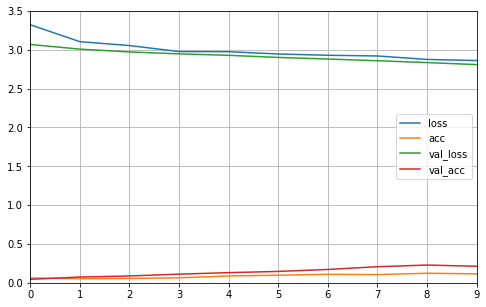

In [46]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3.5)
plt.show()

In [47]:
model.save('models/'+MODEL_NAME+'_model.h5')

# MODEL PREDICITON

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
model = load_model('models/'+MODEL_NAME+'_model.h5')

In [9]:
img_path = 'data/oregon_wildlife/bald_eagle/0a6bf3fa0a0d17aed4.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255.  # Preprocess the image
prediction = model.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

[[7.7603257e-01 3.0139848e-03 8.1859948e-03 2.6428860e-03 4.6272753e-03
  3.5685475e-04 7.1890946e-03 1.7070296e-03 1.0093693e-03 2.5967371e-03
  2.4399566e-03 1.3010452e-03 7.8049949e-03 2.9394792e-03 1.5661061e-01
  1.4729894e-03 1.5488395e-03 1.5227979e-02 1.7680222e-03 1.5242504e-03]]
{'bald_eagle': 0, 'black_bear': 1, 'bobcat': 2, 'canada_lynx': 3, 'columbian_black-tailed_deer': 4, 'cougar': 5, 'coyote': 6, 'deer': 7, 'elk': 8, 'gray_fox': 9, 'gray_wolf': 10, 'mountain_beaver': 11, 'nutria': 12, 'raccoon': 13, 'raven': 14, 'red_fox': 15, 'ringtail': 16, 'sea_lions': 17, 'seals': 18, 'virginia_opossum': 19}
